(200, 200, 3)
[[100 165]
 [125 142]
 [149 125]
 [168 107]
 [162  89]
 [ 68 107]
 [ 54  80]
 [ 46  63]
 [ 42  45]
 [ 84  98]
 [ 81  64]
 [ 79  38]
 [ 78  16]
 [ 97  92]
 [107  52]
 [112  28]
 [116   6]
 [113  92]
 [138  68]
 [152  74]
 [159  88]]


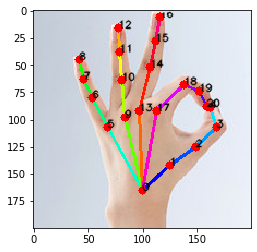

In [3]:
# %load hand.py
import cv2
import json
import numpy as np
import util
import math
import time
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib
from model import handpose_model
import torch
from skimage.measure import label

class Hand(object):
    def __init__(self, model_path):
        self.model = handpose_model()
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        model_dict = util.transfer(self.model, torch.load(model_path))
        self.model.load_state_dict(model_dict)
        self.model.eval()

    def __call__(self, oriImg):
        scale_search = [0.5, 1.0, 1.5, 2.0]
        #scale_search = [0.5]
        boxsize = 368
        stride = 8
        padValue = 128
        thre = 0.05
        multiplier = [x * boxsize / oriImg.shape[0] for x in scale_search]
        heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 22))
        # paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

        for m in range(len(multiplier)):
            scale = multiplier[m]
            imageToTest = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
            imageToTest_padded, pad = util.padRightDownCorner(imageToTest, stride, padValue)
            im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5
            im = np.ascontiguousarray(im)

            data = torch.from_numpy(im).float()
            if torch.cuda.is_available():
                data = data.cuda()
            # data = data.permute([2, 0, 1]).unsqueeze(0).float()
            with torch.no_grad():
                output = self.model(data).cpu().numpy()
                # output = self.model(data).numpy()q

            # extract outputs, resize, and remove padding
            heatmap = np.transpose(np.squeeze(output), (1, 2, 0))  # output 1 is heatmaps
            heatmap = cv2.resize(heatmap, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
            heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
            heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

            heatmap_avg += heatmap / len(multiplier)

        all_peaks = []
        for part in range(21):
            map_ori = heatmap_avg[:, :, part]
            one_heatmap = gaussian_filter(map_ori, sigma=3)
            binary = np.ascontiguousarray(one_heatmap > thre, dtype=np.uint8)
            # 全部小于阈值
            if np.sum(binary) == 0:
                all_peaks.append([0, 0])
                continue
            label_img, label_numbers = label(binary, return_num=True, connectivity=binary.ndim)
            max_index = np.argmax([np.sum(map_ori[label_img == i]) for i in range(1, label_numbers + 1)]) + 1
            label_img[label_img != max_index] = 0
            map_ori[label_img == 0] = 0

            y, x = util.npmax(map_ori)
            all_peaks.append([x, y])
        return np.array(all_peaks)

if __name__ == "__main__":
    hand_estimation = Hand('../model/hand_pose_model.pth')

    # test_image = '../images/hand.jpg'
    test_image = '../images/hand.jpg'
    oriImg = cv2.imread(test_image)  # B,G,R order
    
    print(oriImg.shape)
    peaks = hand_estimation(oriImg)
    
    print(peaks)
    #canvas = util.draw_handpose(oriImg, peaks, True)
    canvas = util.draw_handpose_by_opencv(oriImg, peaks, True)
    
    canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    plt.imshow(canvas)
    plt.show()
